# The begin

In [1]:
bs = 2
tbs = 2

## Переменные для итеративного обучения


In [2]:
import cv2
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data

import scipy.stats as ss

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm

from PIL import Image, ImageDraw, ImageFont
import PIL

import os

import copy
import random
import time

import tracemalloc

%matplotlib inline

In [3]:
def set_random_seed(seed: int = 42, deterministic: bool = False) -> None:
    """
    Seeds all.

    Args:
        seed (int): Seed to be used.
        deterministic (bool): Whether to set the deterministic option for CUDNN backend,
                              i.e., set `torch.backends.cudnn.deterministic` to True and
                              `torch.backends.cudnn.benchmark` to False. Default: False.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.set_printoptions(precision=10)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [4]:
set_random_seed()  # перед каждым запуском обучения

In [5]:
import gc


def cleanup():
    gc.collect()
    torch.cuda.empty_cache()

In [6]:
!pip install levenshtein
!pip install transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.1/174.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 23.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.7 MB/s eta 0:00:00


In [7]:
from transformers import (
    AutoModel,
    AutoTokenizer,
    BertConfig,
    DeiTConfig,
    DeiTModel,
    DeiTFeatureExtractor,
    TrOCRConfig,
    TrOCRProcessor,
    TrOCRForCausalLM,
    ViTConfig,
    ViTModel,
    VisionEncoderDecoderModel,
    VisionEncoderDecoderConfig,
    ViTFeatureExtractor,
)

In [8]:
from google.colab import drive
drive.mount('./data')

Mounted at ./data


In [9]:
cd data/MyDrive/Sber_passports/

/content/data/MyDrive/Sber_passports


In [10]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Inplace generation

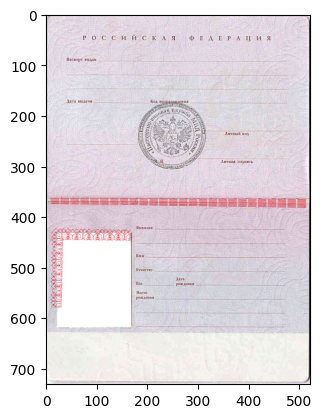

In [11]:
passport_base = Image.open("generation_data/passport_base.jpg")
plt.imshow(passport_base)

### Уголки текстовых полей на паспорте - вычислены вручную

In [12]:
passport_font = "generation_data/arial_0.ttf"
f_corners = np.array([])
with open("generation_data/corners.txt", "r") as file:
    f_corners = np.array(list(map(int, file.readline().split()))).reshape(-1, 2, 2)
p_corners = np.array([
    [22, 430],
    [168, 430],
    [22, 618],
    [168, 618]
])

# TextField class

In [76]:
class TextField:
    passport_font = 'generation_data/arial_0.ttf'
    
    def __init__(self, corners, font_size=15, word="PASSPORT", sep=' '):
        self.corners_ = corners
        self.n_str = corners.shape[0]
        self.font_size = font_size
        self.sep = sep
        if type(word) == str:
            self.word = word
            self.text_splits = ["" for _ in range(self.n_str)]
        else:
            self.word = None
            self.text_splits = word[:self.n_str]
        
    def _write_short(self, img, coordinates_list=None, text=None, line=0, determinized=False):
        """
        Writes one line of a (maybe multi-line) text field, greedy strategy
        img: image to write onto
        coordinates_list: list of text corners coordinates (to append new coordinates to it)
        text: text to write
        line: line of a multi-line text field
        determinized: write text in accurately at the center of the line if True
        else make some augmentations
        """
        text = text if text is not None else self.word
        text = text.strip()
        w, h = img.size
        draw = ImageDraw.Draw(img)
        a, b = draw.textsize(text, font=ImageFont.truetype(passport_font, self.font_size))
        
        y_shift = np.random.choice(np.arange(max(1, b // 2))) * np.random.choice([-1/2, 1]) * (1 - determinized)
        x_shift = np.random.choice(
            np.arange(max(1, (self.corners_[line, 1, 0] - self.corners_[line, 0, 0] - a) // 2))
        ) // 3 * np.random.choice([-1, 1]) * (1 - determinized)
        
        x = (self.corners_[line, 0, 0] + self.corners_[line, 1, 0] - a) // 2 + x_shift
        y = self.corners_[line, 0, 1] - b - y_shift
        draw.text((x, y), text, font=ImageFont.truetype(passport_font, self.font_size), fill=(50, 50, 50))
        self.text_splits[line] = text
        if coordinates_list is not None:
            coordinates_list[line] = [x - 2, y - 2, x + a + 2, y + b + 2]
        return img
    
    def _write_long(self, img, corners_coordinates_list=None, determinized=False):
        """
        Writes a (maybe multi-line) text into text field
        img: image to write onto
        coordinates_list: list of text lines' corners coordinates
        determinized: write text in accurately at the center of the line if True
        else make some augmentations
        """
        draw = ImageDraw.Draw(img)
        words = list(self.word.replace('-', '- ').split())
        lengths = []
        for word in words:
            a, b = draw.textsize(word + " ", font=ImageFont.truetype(passport_font, self.font_size))
            lengths.append(a)
        w, h = img.size
        
        cur_len = 0
        line = 0
        cur_words = []

        field_corners_coordinates_list = [[-1 for _1 in range(4)] for _2 in range(self.n_str)]
        for i in range(len(lengths)):
            if line == self.n_str - 1:
                text = ' '.join(cur_words + words[i:]).replace('- ', '-')
                img = self._write_short(img, field_corners_coordinates_list, line=line, text=text)
                if corners_coordinates_list is not None:
                    corners_coordinates_list += field_corners_coordinates_list
                return img
            cur_words.append(words[i])
            cur_len += lengths[i]
            if cur_len >= self.corners_[line, 1, 0] - self.corners_[line, 0, 0]:
                text = ' '.join(cur_words[:-1]).replace('- ', '-')
                img = self._write_short(img, field_corners_coordinates_list, line=line, text=text)
                cur_words = [words[i]]
                cur_len = lengths[i]
                line += 1
        text = ' '.join(cur_words).replace('- ', '-')
        img = self._write_short(img, field_corners_coordinates_list, line=line, text=text)    

        if corners_coordinates_list is not None:
            corners_coordinates_list += field_corners_coordinates_list
        
        return img

    def fill(self, img, corners_coordinates_list=None, determinized=False):
        if self.word is not None:
            img = self._write_long(
                img,
                corners_coordinates_list=corners_coordinates_list,
                determinized=determinized
            )
        else:
            field_corners_coordinates_list = [[-1 for _1 in range(4)] for _2 in range(self.n_str)]
            self.word = self.sep.join(self.text_splits)
            for i, ts in enumerate(self.text_splits):
                img = self._write_short(
                    img,
                    coordinates_list=field_corners_coordinates_list,
                    text = ts + self.sep if i < len(self.text_splits) - 1 else ts,
                    line=i,
                    determinized=determinized
                )
            if corners_coordinates_list is not None:
                corners_coordinates_list += field_corners_coordinates_list
        return img


# Passport class

In [77]:
class Passport:
    def __init__(
        self,
        f_corners,
        p_corners,
        img, 
        dep="ГУ МВД РОССИИ ПО Г.САНКТ-ПЕТЕРБУРГУ И ЛЕНИНГРАДСКОЙ ОБЛАСТИ",
        p_date="23.06.2012",
        code="000-000",
        surname="МЕЛАДЗЕ",
        name="ВАЛЕРИЙ",
        s_name="ШОТАЕВИЧ",
        sex="МУЖ.",
        b_date="99.99.9999",
        b_place="Г.БАТУМИ",
        photo=Image.open("generation_data/photo_data/men/meladze.jpg")
    ):
        self.f_corners = f_corners.copy()
        self.p_corners = p_corners.copy()
        self.img = img.copy()
        self.img2 = img.copy()
        self.photo = photo.copy()
        self.fields = {
            "department": TextField(self.f_corners[:3], 15, word=dep),
            "passport_date": TextField(self.f_corners[3: 4], 12, word=p_date),
            "code": TextField(self.f_corners[4: 5], 12, word=code),
            "surname": TextField(self.f_corners[5: 7], 15, word=surname, sep='-'),
            "name": TextField(self.f_corners[7: 8], 15, word=name),
            "patron": TextField(self.f_corners[8: 9], 15, word=s_name),
            "sex": TextField(self.f_corners[9: 10], 15, word=sex),
            "birthday": TextField(self.f_corners[10: 11], 12, word=b_date),
            "birth_place": TextField(self.f_corners[11: 14], 15, word=b_place)
        }
        self.real_f_corners = []
        
    def show(self):
        plt.figure(figsize=(10, 16))
        plt.imshow(self.img2)
        
    def clear(self):
        self.img2 = self.img.copy()
        
    def fill(self):
        for field in self.fields:
            self.img2 = self.fields[field].fill(self.img2, self.real_f_corners)
            
    def fill_photo(self):
        self.photo = self.photo.resize(
            (
                self.p_corners[1, 0] - self.p_corners[0, 0],
                self.p_corners[3, 1] - self.p_corners[0, 1]
            )
        )

        passport_np = np.array(self.img2)
        mask_b = passport_np[self.p_corners[0, 1]: self.p_corners[3, 1], self.p_corners[0, 0]: self.p_corners[1, 0], 2]

        mask = (mask_b > 225).astype(np.uint8) * 255
        mask_im = Image.fromarray(mask, mode='L')

        self.img2.paste(self.photo, (self.p_corners[0, 0], self.p_corners[0, 1]), mask_im)

## А теперь попробуем рандомные текстовые поля!

In [148]:
def generate_passport(f_corners, p_corners, base_image, level):
    # letters = list("АЕЁИОУЫЭЮЯБВГДЖЗЙКЛМНПРСТФХЦЧШЩЪЬ-. ")
    letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ-.")
    numbers = list("0123456789")

    # FILL FIX-SIZE FIELDS
    passport_date_nums = np.random.choice(numbers, size=8)
    passport_date = ""
    for n in passport_date_nums:
        passport_date += str(n)
        if len(passport_date) in {2, 5}:
            passport_date += '.'

    code_nums = np.random.choice(numbers, size=6)
    code = ""
    for n in code_nums:
        code += str(n)
        if len(code) == 3:
            code += '-'

    birth_date_nums = np.random.choice(numbers, size=8)
    birth_date = ""
    for n in birth_date_nums:
        birth_date += str(n)
        if len(birth_date) in {2, 5}:
            birth_date += '.'

    sex = ''.join(np.random.choice(letters, size=3)) + '.'

    name = ''.join(np.random.choice(letters, size = max(2, level + np.random.choice(np.arange(-2, 3)))))
    patron = ''.join(np.random.choice(letters, size = max(2, level + np.random.choice(np.arange(-2, 3)))))

    # FILL OTHER FIELDS
    if level >= 10:
        max_plus_words, max_minus_words = 3, 3
        delta_n_words = np.arange(-max_minus_words, max_plus_words + 1)

        department_n_words = 10 + np.random.choice(delta_n_words)
        surname_n_words = np.random.choice([1, 2, 3])
        birth_place_n_words = 5 + np.random.choice(delta_n_words)

        delta_len = [-3, -2, -1, 0, 1, 2, 3]
        department = ' '.join([''.join(np.random.choice(letters, size = 6 + np.random.choice(delta_len))) for _ in range(department_n_words)])
        surname = '-'.join([''.join(np.random.choice(letters, size = 6 + np.random.choice(delta_len))) for _ in range(surname_n_words)])
        birth_place = ' '.join([''.join(np.random.choice(letters, size = 6 + np.random.choice(delta_len))) for _ in range(birth_place_n_words)])
    else:
        department_n_lines = np.random.choice([1, 2, 3])
        surname_n_lines = np.random.choice([1, 2])
        birth_place_n_lines = np.random.choice([1, 2, 3])

        delta_len = [-2, -1, 0, 1, 2]
        department = [''.join(np.random.choice(letters, size = max(2, level + np.random.choice(delta_len)))) for _ in range(department_n_lines)]
        surname = [''.join(np.random.choice(letters, size = max(2, level + np.random.choice(delta_len)))) for _ in range(surname_n_lines)]
        birth_place = [''.join(np.random.choice(letters, size = max(2, level + np.random.choice(delta_len)))) for _ in range(birth_place_n_lines)]

    photo_from = 'men' if np.random.randint(1) else 'women'
    passport = Passport(
            f_corners,
            p_corners, 
            base_image, 
            dep=department,
            code=code,
            surname=surname, 
            name=name, 
            s_name=patron,
            sex=sex,
            p_date=passport_date,
            b_date=birth_date,
            b_place=birth_place,
            photo = Image.open("generation_data/photo_data/" + photo_from + '/' + np.random.choice(os.listdir(f"generation_data/photo_data/{photo_from}")))
        )
    passport.fill()
    passport.fill_photo()

    return passport

# Теперь можно: Датасет и даталоадер
Первая часть модели отвечает за нахождение региончиков с текстом.  
Происходит патчевая классификация. То есть таргет для картинки - это 2d тензор размера *\[H/P, W/P\]*, где для каждого патча выставлен класс, к которому от относится.  
Классов всего 16: 14 видов текстовых полей + *'photo'* + *'blank'*

In [149]:
class PassportDataset(Dataset):
    def __init__(self, size, level, processor, w=320, h=640, p=4):
        """
        pd_table - path to the dataset
        img_dir - directory with passport images
        w, h - the desirable size of the image (to resize)
        p - patch size
        from_, to_ - set them to take a part of a dataset, not the whole
        """
        self.processor = processor
        self.p = p
        self.size = size
        self.level = level
        self.shape = (w, h)  # shape: x, y - for PIL image
        self.pshape = (h // p, w // p)  # sape: y, x - for torch.tensor
        self.transforms = transforms.Compose([
            transforms.Resize(self.shape[::-1]),
            transforms.ColorJitter(brightness=(0.9, 1.1), contrast=(0.8, 1.25)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        passport = generate_passport(f_corners, p_corners, passport_base, self.level)
        image = passport.img2
        W, H = image.size
        mw, mh = self.shape[0] / W, self.shape[1] / H  # mult-W, mult-H
        tensor = self.transforms(image)
        del image
        
        fields_coords = passport.real_f_corners
        fields_coords.append([22, 430, 168, 618])
        fields_coords = np.array(fields_coords)
        fields_coords[:, 0::2] *= mw
        fields_coords[:, 1::2] *= mh

        labels = torch.zeros(self.pshape)

        def top_left(x):
            return int(np.floor(x / self.p))
        
        def bottom_right(x):
            return int(np.ceil(x / self.p))

        for k in range(len(fields_coords)):
            coords = fields_coords[k]
            if coords[0] == -1:
                continue
            labels[top_left(coords[1]): bottom_right(coords[3]), top_left(coords[0]): bottom_right(coords[2])] = k + 1

        fields = ("department", "passport_date", "code", "surname", "name", "patron", "sex", "birthday", "birth_place")
        texts = []
        for field in fields:
            texts += passport.fields[field].text_splits

        texts = torch.tensor(self.processor.tokenizer(texts, padding="max_length", max_length=32).input_ids)

        return {"X": tensor, "target_img": labels.long(), "texts": texts}

In [150]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-handwritten')

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [151]:
train_data = PassportDataset(80, 10, processor, p=8)
test_data = PassportDataset(20, 10, processor, p=8)

In [155]:
d = train_data[5]
x, y, t = d["X"], d["target_img"], d["texts"]
print(t.shape)

torch.Size([14, 32])


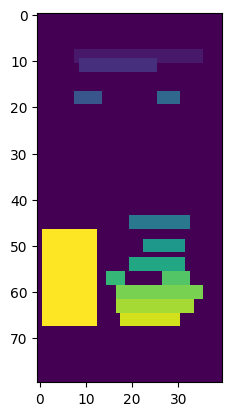

In [156]:
topil = transforms.ToPILImage()
pic = topil(x)
plt.imshow(y)

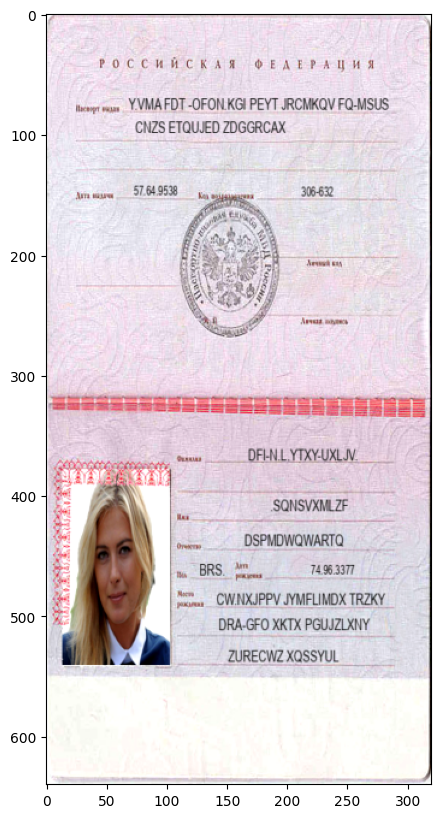

In [157]:
plt.figure(figsize=(16, 10))
plt.imshow(pic)

In [158]:
pic.save("crop_samples/hard_sintetic.jpg")

In [23]:
train_dataloader = DataLoader(train_data, batch_size=bs, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=bs, shuffle=True)

In [24]:
for x in train_dataloader:
    print(x["texts"].shape)
    break

torch.Size([2, 14, 32])


# Patch embeddings

In [25]:
class TwoConvLayer(nn.Module):
    """
    Special embedding layer.
    Takes a patch C x H x W
    Applies a convolution -> 1 x H' x W'
    Flattens -> H'W'
    Applies a linear layer to embed size
    """
    def __init__(self, out_size, h, w, c=3, hidden_size=3, kernel_size=3):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(c, hidden_size, kernel_size=kernel_size),
            nn.LayerNorm([hidden_size, h - kernel_size + 1, w - kernel_size + 1]),
            nn.Dropout(),
            nn.Conv2d(hidden_size, out_size, kernel_size=(h - kernel_size + 1, w - kernel_size + 1)),
        )

    def forward(self, x):
        return self.layers(x)


class NConvLayer(nn.Module):
    """
    Special embedding layer.
    Takes a patch C x H x W
    Applies a convolution -> 1 x H' x W'
    Flattens -> H'W'
    Applies a linear layer to embed size
    """
    def __init__(self, N, out_size, h, w, c=3, hidden_size=3, kernel_size=3):
        assert N > 2
        if type(hidden_size) == list:
            assert len(hidden_size) == N - 1
            hidden_size = [c] + hidden_size
        else:
            hidden_size = [c] + [hidden_size for _ in range(N - 1)]

        super().__init__()

        self.first_conv_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(hidden_size[i - 1], hidden_size[i], kernel_size=3, padding=1),
                nn.LayerNorm([hidden_size[i], h, w]),
                nn.Dropout(),
            ) for i in range(1, len(hidden_size) - 1)
        ])
        self.pre_last_layer = nn.Sequential(
            nn.Conv2d(hidden_size[-2], hidden_size[-1], kernel_size=kernel_size),
            nn.LayerNorm([hidden_size[-1], h - kernel_size + 1, w - kernel_size + 1]),
            nn.Dropout(),
        )
        self.final_layer = nn.Conv2d(hidden_size[-1], out_size, kernel_size=(h - kernel_size + 1, w - kernel_size + 1))

    def forward(self, x):
        for layer in self.first_conv_layers:
            x = layer(x)
        x = self.pre_last_layer(x)
        return self.final_layer(x)

    
class SimplePatchEmbedding(nn.Module):
    def __init__(self, h, w, patch_size=8, patch_embed_size=8, input_channels=3):
        assert w % patch_size == 0 and h % patch_size == 0
        super().__init__()
        self.h, self.w = h, w
        self.layers = nn.Sequential(
            nn.Conv2d(input_channels, patch_embed_size, kernel_size=patch_size, stride=patch_size),
            nn.LayerNorm([patch_embed_size, h // patch_size, w // patch_size]),
        )

    def forward(self, x):
        n_dims = len(x.shape)
        assert x.shape[3 - int(n_dims == 3)] == self.w and x.shape[2 - int(n_dims == 3)]
        return self.layers(x)

    
class NConvPatchEmbedding(nn.Module):
    def __init__(self, N, h, w, patch_size=8, patch_embed_size=8, input_channels=3, hidden_size=3, final_kernel_size=3):
        """
        w, h - size of an input image, in pixels - is needed to know the number of linear/conv layers
        """
        assert w % patch_size == 0 and h % patch_size == 0
        super().__init__()

        self.p = patch_size
        self.patch_embed_size = patch_embed_size
        self.w, self.h = w, h
        self.layer = NConvLayer(N, self.patch_embed_size, self.p, self.p, c=input_channels, hidden_size=hidden_size, kernel_size=final_kernel_size)
        self.wp, self.hp = self.w // self.p, self.h // self.p

    def forward(self, x):
        n_dims = len(x.shape)
        if n_dims == 3:
            x = x[None, :, :, :]  # Make batch if no batch
        assert x.shape[2] == self.h and x.shape[3] == self.w

        batch_size = x.shape[0]

        embedded = []
        for j in range(self.hp):
            for i in range(self.wp):
                x_patch = x[:, :, self.p * j: self.p * (j + 1), self.p * i: self.p * (i + 1)]
                embedded.append(self.layer(x_patch)[:, None, :])
        embedded = torch.stack(embedded, dim=1).reshape(batch_size, self.hp, self.wp, self.patch_embed_size).transpose(2, 3).transpose(1, 2)

        return embedded if n_dims == 4 else embedded[0]


class HeavyPatchEmbedding(nn.Module):
    def __init__(self, h, w, patch_size=8, patch_embed_size=8, input_channels=3, embed_type='linear'):
        """
        embed_size - size of embedding vectors
        pathc_size - size of a patch in pixels
        embed_type - one of ['linear', 'conv', '2conv']
        w, h - size of an input image, in pixels - is needed to know the number of linear/conv layers
        """
        assert w % patch_size == 0 and h % patch_size == 0

        super().__init__()

        self.device = device
        self.embed_size = patch_embed_size
        self.p = patch_size
        self.w, self.h, self.c = w, h, input_channels
        self.wp, self.hp = self.w // self.p, self.h // self.p
        self.embed_type = embed_type

        if self.embed_type == 'linear':
            self.layers = nn.ModuleList([nn.Linear(self.p ** 2 * self.c, self.embed_size) for _ in range(self.wp * self.hp)])
        elif self.embed_type == 'conv':
            self.layers = nn.ModuleList([nn.Conv2d(self.c, self.embed_size, kernel_size=self.p) for _ in range(self.wp * self.hp)])
        elif self.embed_type == '2conv':
            self.layers = nn.ModuleList([TwoConvLayer(self.embed_size, self.p, self.p) for _ in range(self.wp * self.hp)])
        else:
            raise ValueError("embed_type should be one of 'linear', 'conv', '2conv'")

    def forward(self, x):
        n_dims = len(x.shape)
        if n_dims == 3:
            x = x[None, :, :, :]  # Make batch if no batch
        assert x.shape[2] == self.h and x.shape[3] == self.w

        batch_size = x.shape[0]

        embedded = []
        for j in range(self.hp):
            for i in range(self.wp):
                x_patch = x[:, :, self.p * j: self.p * (j + 1), self.p * i: self.p * (i + 1)]
                if self.embed_type == 'linear':
                    x_patch = x_patch.flatten(1, -1)
                embedded.append(self.layers[self.wp * j + i](x_patch)[:, None, :])
        embedded = torch.stack(embedded, dim=1).reshape(batch_size, self.hp, self.wp, self.embed_size).transpose(2, 3).transpose(1, 2)

        return embedded if n_dims == 4 else embedded[0]


In [26]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Распознавание

### Модель для кроппинга и составления батчей из кропов

In [27]:
class ImageCropper(nn.Module):
    """
    На вход принимается картинка HxW
    После patch embedding будет размер (H/p)x(W/p)
    """

    def pos_embedding(self):
        x = torch.tensor([list(range(self.WP)) for _ in range(self.HP)]) / self.WP
        y = torch.tensor([list(range(self.HP)) for _ in range(self.WP)]).T / self.HP
        return torch.stack([x, y]).to(self.device)

    def __init__(
        self,
        device,
        patch_embed_layer,
        patch_size=8,
        patch_embed_size=8,
        n_classes=16,
        W=320,
        H=640,
        pos_embed=True,
        pos_embed_stack=True,
        hidden_size=None,
    ):
        self.W, self.H = W, H
        assert self.W % patch_size == 0 and self.H % patch_size == 0

        super().__init__()

        self.pos_embed = pos_embed
        self.pos_embed_stack=True
        self.device = device
        self.p = patch_size
        self.h = patch_embed_size + 2 * int(self.pos_embed and self.pos_embed_stack)
        self.WP, self.HP = self.W // self.p, self.H // self.p
        self.n_classes = n_classes
        self.hidden_size = hidden_size or self.h // 2 + 1

        self.patch_embed = patch_embed_layer
        self.norm1 = nn.Sequential(
            nn.LayerNorm([self.h, self.HP, self.WP]),
            nn.Dropout(),
        )

        self.conv_norm = nn.Sequential(
            nn.Conv2d(self.h, self.hidden_size, kernel_size=3, padding=1),
            nn.LayerNorm([self.hidden_size, self.HP, self.WP]),
            nn.Dropout(),
        )

        self.patch_to_logit = nn.Conv2d(self.hidden_size, self.n_classes, kernel_size=1)

    def forward(self, x):
        # Classification
        n_dims = len(x.shape)
        x = x if n_dims == 4 else x[None, :, :, :]

        x_patched = self.patch_embed(x)
        if self.pos_embed:
            if self.pos_embed_stack:
                pos_embedding = torch.stack([self.pos_embedding() for _ in range(x.shape[0])])
                x_patched = torch.concat([x_patched, pos_embedding], dim=1)
            else:
                x_patched += self.pos_embeddig()
        x_patched = self.norm1(x_patched)
        x_patched = self.conv_norm(x_patched)
        logits = self.patch_to_logit(x_patched)

        return logits if n_dims == 4 else logits[0]

    def _make_crop_batches(self, x, logits):
        # Clusterization and denoising
        predictions = logits.argmax(dim=1)
        crops_coords = []
        crops_max_sizes = [[-1, -1] for _ in range(1, 15)]
        for idx in range(predictions.shape[0]):
            idx_crops_coords = []
            for k in range(1, 15):
                vy, vx = torch.where(predictions[idx] == k)
                if len(vx) == 0:
                    idx_crops_coords.append((-1, -1, -1, -1))
                    continue
                xmin, xmax = torch.quantile(vx.type(torch.float32).to('cpu'), q=torch.tensor([0.1, 0.9]), interpolation='lower')
                ymin, ymax = torch.quantile(vy.type(torch.float32).to('cpu'), q=torch.tensor([0.2, 0.8]), interpolation='lower')
                xmin, xmax, ymin, ymax = map(int, (xmin, xmax, ymin, ymax))
                crops_max_sizes[k - 1][0] = max(crops_max_sizes[k - 1][0], (xmax - xmin + 3) * self.p)
                crops_max_sizes[k - 1][1] = max(crops_max_sizes[k - 1][1], (ymax - ymin + 1) * self.p)
                idx_crops_coords.append((ymin * self.p, (ymax + 1) * self.p, max(0, xmin - 1) * self.p, min(x.shape[3], (xmax + 2) * self.p)))
            crops_coords.append(idx_crops_coords)

        # Now we have crops coordinates for all fields and batch elements

        # Now let's make batches to feed them to the transformer model
        new_batches = [torch.ones((x.shape[0], x.shape[1], my, mx)).to(self.device) if (mx >= 0 and my >= 0) else None for mx, my in crops_max_sizes]
        for k in range(1, 15):
            for idx in range(predictions.shape[0]):
                if new_batches[k - 1] is not None and crops_coords[idx][k - 1] != (-1, -1, -1, -1):
                    ymin, ymax, xmin, xmax = crops_coords[idx][k - 1]
                    new_batches[k - 1][idx, :, :(ymax - ymin), :(xmax - xmin)] = x[idx, :, ymin: ymax, xmin: xmax]

        return new_batches

### Модель для распознавания

In [28]:
class PassportRecognition(nn.Module):
    def __init__(self, processor, crop_model, ocr_model, device='cpu', max_length=32):
        super().__init__()
        self.processor = processor
        self.cropper = crop_model
        self.recognizer = ocr_model
        self.max_length = max_length
        self.device = device
        self.back_transform = transforms.ToPILImage()

    def forward(self, x, labels, tbs=None, save=False):
        """
        tbs: transformer batch size
        x should be on cpu
        """
        tbs = tbs or x.shape[0]
        logits = self.cropper(x.to(self.device)).to('cpu')
        cleanup()
        new_batches = self.cropper._make_crop_batches(x, logits)

        if save:
            for i, batch in tqdm(enumerate(new_batches), total=len(new_batches), desc="Saving samples"):
                if batch is not None:
                    img = self.back_transform(batch[0])
                    img.save(f"crop_samples/crop_{i}.jpg")

        loss_sum, loss_cnt = 0., 0
        for i, batch in tqdm(enumerate(new_batches), total=len(new_batches)):
            if batch is not None:
                for k in range(0, batch.shape[0], tbs):
                    pixels = processor(batch[k: k + tbs], return_tensors="pt").pixel_values.to(self.device)
                    targets = labels[k: k + tbs, i, :].to(self.device)
                    loss_sum += self.recognizer(pixel_values=pixels, labels=targets).loss
                    loss_cnt += 1
                    del pixels, targets
                    cleanup()
            
        del labels, new_batches
        cleanup()

        return logits, (loss_sum / loss_cnt) if loss_cnt else 0.

    def generate(self, x, tbs=None):
        """
        tbs: transformer batch size
        """
        tbs = tbs or x.shape[0]
        logits = self.cropper(x.to(self.device)).to('cpu')
        cleanup()
        new_batches = self.cropper._make_crop_batches(x, logits)
        sequences = []
        for i, batch in tqdm(enumerate(new_batches), total=len(new_batches)):
            if batch is not None:
                cls_sequences = []
                for k in range(0, batch.shape[0], tbs):
                    pixels = processor(batch[k: k + tbs], return_tensors="pt").pixel_values.to(self.device)
                    cls_sequences.append(self.recognizer.generate(pixels, max_length=self.max_length).to('cpu'))
                    del pixels
                    cleanup()
                sequences.append(torch.concat(cls_sequences))
            else:
                sequences.append(None)
            
        del new_batches
        cleanup()

        return sequences

# Свои train и eval

In [29]:
import Levenshtein as pylev

In [30]:
def train_full(model, train_data, criterion_crop, optimizer, device, tbs=None):
    model.train()
    epoch_crop_loss, epoch_recognize_loss = 0, 0
    normal_crop_loss = 0.1

    for data in tqdm(train_data, desc="Training"):
        X, y = data["X"], data["target_img"]
        texts = data["texts"]

        model.zero_grad()
        logits, loss_recognize = model(X, texts, tbs)

        cleanup()

        logits = logits.to('cpu').transpose(1, 2).transpose(2, 3).flatten(0, 2)
        cleanup()
        y = y.flatten()

        loss_crop = criterion_crop(logits, y)
        crop_weight = (loss_crop.item() / normal_crop_loss) ** 2
        crop_weight /= (crop_weight + 1)
        recognize_weight = 1. - crop_weight
        print(crop_weight, recognize_weight)

        # decrease recognize_weight
        loss = loss_crop * crop_weight + loss_recognize * recognize_weight * 1e-02
        loss.backward()

        optimizer.step()

        epoch_crop_loss += loss_crop.item()
        epoch_recognize_loss += loss_recognize if type(loss_recognize) == float else loss_recognize.item()
 
        del X, y, texts
        cleanup()

    return epoch_crop_loss / len(train_data), epoch_recognize_loss / len(train_data)


def evaluate_full(model, val_data, criterion_crop, device, tbs=None, save=True):
    model.eval()
    epoch_crop_loss, epoch_recognize_loss = 0, 0
    accuracy_score0, accuracy_score1 = 0, 0
    accuracy_total0, accuracy_total1 = 0, 0
    with torch.no_grad():
        for data in tqdm(val_data, desc="Evaluating"):
            X, y = data["X"], data["target_img"]
            texts = data["texts"]

            logits, loss_recognize = model(X, texts, tbs=tbs, save=save)

            cleanup()

            logits = logits.to('cpu').transpose(1, 2).transpose(2, 3).flatten(0, 2)
            y = y.flatten()
            loss_crop = criterion_crop(logits, y)

            pred_classes = logits.argmax(dim=1)

            if save:
                plt.imsave("crop_samples/target.jpg", y.reshape(2, 80, 40)[0])
                plt.imsave("crop_samples/prediction.jpg", pred_classes.reshape(2, 80, 40)[0])
                save = False

            mask0 = y > 0
            mask1 = (y > 0) | (pred_classes > 0)
            accuracy_score0 += (y[mask0] == pred_classes[mask0]).sum()
            accuracy_total0 += len(y[mask0])
            accuracy_score1 += (y[mask1] == pred_classes[mask1]).sum()
            accuracy_total1 += len(y[mask1])

            epoch_crop_loss += loss_crop.item()
            epoch_recognize_loss += loss_recognize if type(loss_recognize) == float else loss_recognize.item()

            del X, y, texts
            cleanup()

    return epoch_crop_loss / len(val_data), epoch_recognize_loss / len(val_data), (accuracy_score0 / accuracy_total0, accuracy_score1 / accuracy_total1)


def count_levenshtein(model, val_data, device, tbs=None):
    model.eval()
    epoch_lev_dist = []
    with torch.no_grad():
        for data in tqdm(val_data, desc="Evaluating levenstein"):        
            X, y = data["X"], data["target_img"]
            texts = data["texts"]

            outputs = model.generate(X, tbs)
            cleanup()

            targets = [model.processor.batch_decode(texts[:, k, :], skip_special_tokens=True) for k in range(texts.shape[1]) if outputs[k] is not None]
            preds = [model.processor.batch_decode(output, skip_special_tokens=True) for output in outputs if output is not None]

            for k in range(len(preds)):
                for pred, target in zip(preds[k], targets[k]):
                    if np.random.randint(100) < 4:
                        print(f"[{pred}] vs [{target}]")
                    epoch_lev_dist.append(pylev.distance(pred, target))

            del X, y, texts
            cleanup()

    return np.mean(epoch_lev_dist)

# Final train

In [31]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-handwritten')
recognize_model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-small-handwritten')

recognize_model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
recognize_model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
recognize_model.config.vocab_size = recognize_model.config.decoder.vocab_size

# set beam search parameters
recognize_model.config.eos_token_id = processor.tokenizer.sep_token_id
recognize_model.config.max_length = 64
recognize_model.config.early_stopping = True
recognize_model.config.no_repeat_ngram_size = 3
recognize_model.config.length_penalty = 1.0
recognize_model.config.num_beams = 3

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
processor

TrOCRProcessor:
- image_processor: DeiTImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": false,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "DeiTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 384,
    "width": 384
  }
}

- tokenizer: XLMRobertaTokenizerFast(name_or_path='microsoft/trocr-small-handwritten', vocab_size=64002, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)}, clean_up_tokenization_spaces=True)

In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_classes = 16

crop_model = ImageCropper(
    device,
    NConvPatchEmbedding(
        3,
        640,
        320,
        patch_embed_size=16,
        hidden_size=[8, 8],
    ),
    pos_embed_stack=True,
    patch_size=8,
    patch_embed_size=16,
    hidden_size=16,
    n_classes=n_classes,
)

model = PassportRecognition(processor, crop_model, recognize_model, device=device)
model.to(device)

class_weights = [
    1.,  # blank
    100.,  # department-1 
    200.,  # department-2
    250.,  # department-3
    100.,  # passport date
    100.,  # department code
    100.,  # surname-1
    150.,  # surname-2
    100.,  # name
    100.,  # last name
    100.,  # sex
    100.,  # birth date
    100.,  # birth place 1
    150.,  # birth place 2
    200.,  # birth place 3
    100.,  # photo
]
criterion_crop = nn.CrossEntropyLoss(weight=torch.tensor(class_weights))
optimizer = optim.Adam(model.parameters(), lr=1e-2)

# warmup_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1e-3, total_iters=5)
gamma_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.25)
# lr_scheduler = optim.lr_scheduler.SequentialLR(optimizer, schedulers=[warmup_scheduler, gamma_scheduler], milestones=[5])
lr_scheduler = gamma_scheduler

f"Working on {device}"

'Working on cuda'

In [34]:
EPOCHS = 30
train_crop_loss_storage, valid_crop_loss_storage = [], []
train_recognize_loss_storage, valid_recognize_loss_storage = [], []

valid_crop_loss, valid_recognize_loss, accuracy_score = evaluate_full(model, test_dataloader, criterion_crop, device, tbs=tbs)
valid_lev_dist = count_levenshtein(model, test_dataloader, device)
print('Before training')
print(f'\t Val. cropping loss: {valid_crop_loss:.3f}')
print(f'\t Val. recognizing loss: {valid_recognize_loss:.3f}')
print(f'\t Where target not zero. Val. Accuracy: {accuracy_score[0]:.3f}')
print(f'\t Where target or pred not zero. Val. Accuracy: {accuracy_score[1]:.3f}')
print(f'\t Val. Levenshein distance: {valid_lev_dist:.3f}')

best_valid_loss = valid_recognize_loss

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Saving samples:   0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Evaluating levenstein:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1255: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[in] vs []
[more than] vs [48.77.7767]
[in] vs []


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[in] vs []
[in] vs []
[in] vs [YPBSW]


  0%|          | 0/14 [00:00<?, ?it/s]

[more than] vs [VYW.CV]
Before training
	 Val. cropping loss: 2.878
	 Val. recognizing loss: 16.696
	 Where target not zero. Val. Accuracy: 0.025
	 Where target or pred not zero. Val. Accuracy: 0.004
	 Val. Levenshein distance: 16.783


In [ ]:
levels = [2, 3, 5, 7, 10]

for epoch in range(EPOCHS):
    if epoch % 6 == 0:
        train_data = PassportDataset(80, levels[epoch // 6], processor, p=8)
        test_data = PassportDataset(20, levels[epoch // 6], processor, p=8)
        train_dataloader = DataLoader(train_data, batch_size=bs, shuffle=True)
        test_dataloader = DataLoader(test_data, batch_size=bs, shuffle=True)

    print(f"Epoch #{epoch + 1}")
    start_time = time.monotonic()

    train_crop_loss, train_recognize_loss = train_full(model, train_dataloader, criterion_crop, optimizer, device, tbs=tbs)
    train_crop_loss_storage.append(train_crop_loss)
    train_recognize_loss_storage.append(train_recognize_loss)

    valid_crop_loss, valid_recognize_loss, accuracy_score = evaluate_full(model, test_dataloader, criterion_crop, device, tbs=tbs)
    valid_crop_loss_storage.append(valid_crop_loss)
    valid_recognize_loss_storage.append(valid_recognize_loss)

    if valid_recognize_loss < best_valid_loss:
        best_valid_loss = valid_recognize_loss
        torch.save(model.state_dict(), f'models_backups/inplace_full_recognizer_v3_best.pt')
    torch.save(model.state_dict(), f'models_backups/inplace_full_recognizer_v3_latest.pt')

    valid_vel_dist = count_levenshtein(model, test_dataloader, device)

    lr_scheduler.step()
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain crop loss: {train_crop_loss:.3f};\t Train recognize loss: {train_recognize_loss:.3f}')
    print(f'\tVal. crop loss: {valid_crop_loss:.3f};\t Val. recognize loss: {valid_recognize_loss:.3f}')
    print(f'\t Where target not zero. Val. Accuracy: {accuracy_score[0]:.3f}')
    print(f'\t Where target or pred not zero. Val. Accuracy: {accuracy_score[1]:.3f}')
    print(f'\t Val. Levenshein distance: {valid_lev_dist:.3f}')

    cleanup()

Epoch #1


Training:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.5931299713577675 0.40687002864223254


  0%|          | 0/14 [00:00<?, ?it/s]

0.6862664039379544 0.31373359606204565


  0%|          | 0/14 [00:00<?, ?it/s]

0.8584631228117656 0.14153687718823438


  0%|          | 0/14 [00:00<?, ?it/s]

0.5961519191005192 0.40384808089948077


  0%|          | 0/14 [00:00<?, ?it/s]

0.7028724106781659 0.29712758932183414


  0%|          | 0/14 [00:00<?, ?it/s]

0.6672190340930859 0.3327809659069141


  0%|          | 0/14 [00:00<?, ?it/s]

0.5954289278455126 0.4045710721544874


  0%|          | 0/14 [00:00<?, ?it/s]

0.6266092459477217 0.3733907540522783


  0%|          | 0/14 [00:00<?, ?it/s]

0.6668692428555436 0.3331307571444564


  0%|          | 0/14 [00:00<?, ?it/s]

0.6013471419535016 0.3986528580464984


  0%|          | 0/14 [00:00<?, ?it/s]

0.6331618974967229 0.3668381025032771


  0%|          | 0/14 [00:00<?, ?it/s]

0.9216229355072125 0.07837706449278747


  0%|          | 0/14 [00:00<?, ?it/s]

0.7137533051266971 0.2862466948733029


  0%|          | 0/14 [00:00<?, ?it/s]

0.5773489811715945 0.4226510188284055


  0%|          | 0/14 [00:00<?, ?it/s]

0.61079431518894 0.38920568481106


  0%|          | 0/14 [00:00<?, ?it/s]

0.7380436487620012 0.26195635123799876


  0%|          | 0/14 [00:00<?, ?it/s]

0.7144953315291848 0.28550466847081524


  0%|          | 0/14 [00:00<?, ?it/s]

0.6434084469553943 0.35659155304460566


  0%|          | 0/14 [00:00<?, ?it/s]

0.8226536628356368 0.1773463371643632


  0%|          | 0/14 [00:00<?, ?it/s]

0.7895477772835375 0.21045222271646247


  0%|          | 0/14 [00:00<?, ?it/s]

0.60807146134359 0.39192853865641


  0%|          | 0/14 [00:00<?, ?it/s]

0.6478997934105317 0.3521002065894683


  0%|          | 0/14 [00:00<?, ?it/s]

0.6122157873965842 0.3877842126034158


  0%|          | 0/14 [00:00<?, ?it/s]

0.8684085210826684 0.13159147891733158


  0%|          | 0/14 [00:00<?, ?it/s]

0.6298515353006332 0.3701484646993668


  0%|          | 0/14 [00:00<?, ?it/s]

0.8734414199869406 0.12655858001305942


  0%|          | 0/14 [00:00<?, ?it/s]

0.6283771223633914 0.3716228776366086


  0%|          | 0/14 [00:00<?, ?it/s]

0.5811847145572463 0.4188152854427537


  0%|          | 0/14 [00:00<?, ?it/s]

0.6455788058848798 0.3544211941151202


  0%|          | 0/14 [00:00<?, ?it/s]

0.5990286432006893 0.40097135679931073


  0%|          | 0/14 [00:00<?, ?it/s]

0.7532152920227069 0.24678470797729313


  0%|          | 0/14 [00:00<?, ?it/s]

0.689079888325609 0.31092011167439104


  0%|          | 0/14 [00:00<?, ?it/s]

0.5762205033171978 0.42377949668280224


  0%|          | 0/14 [00:00<?, ?it/s]

0.618382776502016 0.381617223497984


  0%|          | 0/14 [00:00<?, ?it/s]

0.6221532585883046 0.3778467414116954


  0%|          | 0/14 [00:00<?, ?it/s]

0.6461326325622814 0.3538673674377186


  0%|          | 0/14 [00:00<?, ?it/s]

0.8223378556014942 0.1776621443985058


  0%|          | 0/14 [00:00<?, ?it/s]

0.6780265714076666 0.32197342859233335


  0%|          | 0/14 [00:00<?, ?it/s]

0.8953695409466036 0.10463045905339641


  0%|          | 0/14 [00:00<?, ?it/s]

0.5420567288825611 0.45794327111743893


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Saving samples:   0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Evaluating levenstein:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [86.38.8087]


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [SPB.]


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [YOMVM VZQDFVFW YCTA]


  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [CQEK.PCT]


  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [DNGCTQNO ADYARUM WUFSJ]


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [MXA.]
[] vs [33.30.1038]
[] vs [EIDTG]


  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [JG.LVU OPGBROOW KA-EQ KZIUH AIN-ND-]
Epoch: 01 | Epoch Time: 10m 12s
	Train crop loss: 0.158;	 Train recognize loss: 2.116
	Val. crop loss: 0.073;	 Val. recognize loss: 2.115
	 Where target not zero. Val. Accuracy: 0.990
	 Where target or pred not zero. Val. Accuracy: 0.642
	 Val. Levenshein distance: 16.783
Epoch #2


Training:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.47251052323518233 0.5274894767648177


  0%|          | 0/14 [00:00<?, ?it/s]

0.5509340709704352 0.44906592902956477


  0%|          | 0/14 [00:00<?, ?it/s]

0.7234001739109381 0.27659982608906186


  0%|          | 0/14 [00:00<?, ?it/s]

0.5683932565748661 0.43160674342513394


  0%|          | 0/14 [00:00<?, ?it/s]

0.5967483924408369 0.4032516075591631


  0%|          | 0/14 [00:00<?, ?it/s]

0.6232186190326515 0.3767813809673485


  0%|          | 0/14 [00:00<?, ?it/s]

0.6082499474117539 0.39175005258824613


  0%|          | 0/14 [00:00<?, ?it/s]

0.6828892024052121 0.3171107975947879


  0%|          | 0/14 [00:00<?, ?it/s]

0.778474925654427 0.221525074345573


  0%|          | 0/14 [00:00<?, ?it/s]

0.5844012216905926 0.4155987783094074


  0%|          | 0/14 [00:00<?, ?it/s]

0.5737774879389149 0.4262225120610851


  0%|          | 0/14 [00:00<?, ?it/s]

0.8465020307688942 0.1534979692311058


  0%|          | 0/14 [00:00<?, ?it/s]

0.5653298328040824 0.43467016719591756


  0%|          | 0/14 [00:00<?, ?it/s]

0.6681195438261991 0.3318804561738009


  0%|          | 0/14 [00:00<?, ?it/s]

0.5926500373320278 0.4073499626679722


  0%|          | 0/14 [00:00<?, ?it/s]

0.5997013154766272 0.4002986845233728


  0%|          | 0/14 [00:00<?, ?it/s]

0.6069227267178873 0.3930772732821127


  0%|          | 0/14 [00:00<?, ?it/s]

0.5631153536658793 0.4368846463341207


  0%|          | 0/14 [00:00<?, ?it/s]

0.6700611764923677 0.32993882350763226


  0%|          | 0/14 [00:00<?, ?it/s]

0.6446790284535346 0.35532097154646536


  0%|          | 0/14 [00:00<?, ?it/s]

0.6781721941470512 0.3218278058529488


  0%|          | 0/14 [00:00<?, ?it/s]

0.6117730589041643 0.38822694109583566


  0%|          | 0/14 [00:00<?, ?it/s]

0.65006175566803 0.34993824433196996


  0%|          | 0/14 [00:00<?, ?it/s]

0.5431409833815583 0.45685901661844175


  0%|          | 0/14 [00:00<?, ?it/s]

0.556541275231473 0.443458724768527


  0%|          | 0/14 [00:00<?, ?it/s]

0.5984553049664257 0.40154469503357426


  0%|          | 0/14 [00:00<?, ?it/s]

0.7134025946640494 0.2865974053359506


  0%|          | 0/14 [00:00<?, ?it/s]

0.5896251458009596 0.4103748541990404


  0%|          | 0/14 [00:00<?, ?it/s]

0.5948854616200612 0.4051145383799388


  0%|          | 0/14 [00:00<?, ?it/s]

0.5989826952791378 0.40101730472086217


  0%|          | 0/14 [00:00<?, ?it/s]

0.698888991958983 0.301111008041017


  0%|          | 0/14 [00:00<?, ?it/s]

0.6529594676822209 0.3470405323177791


  0%|          | 0/14 [00:00<?, ?it/s]

0.6069654087220392 0.3930345912779608


  0%|          | 0/14 [00:00<?, ?it/s]

0.5025296788054127 0.49747032119458734


  0%|          | 0/14 [00:00<?, ?it/s]

0.5085334723047059 0.4914665276952941


  0%|          | 0/14 [00:00<?, ?it/s]

0.8141392206337391 0.1858607793662609


  0%|          | 0/14 [00:00<?, ?it/s]

0.5061991331148664 0.4938008668851336


  0%|          | 0/14 [00:00<?, ?it/s]

0.7962776621418349 0.20372233785816507


  0%|          | 0/14 [00:00<?, ?it/s]

0.6829306708229979 0.31706932917700215


  0%|          | 0/14 [00:00<?, ?it/s]

0.6388137000849105 0.36118629991508955


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Saving samples:   0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Evaluating levenstein:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [501-214]


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [11.13.0471]


  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [BUG.Y]


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [OBFDZV]
[] vs [53.87.6411]


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 10m 6s
	Train crop loss: 0.134;	 Train recognize loss: 2.080
	Val. crop loss: 0.065;	 Val. recognize loss: 2.185
	 Where target not zero. Val. Accuracy: 0.990
	 Where target or pred not zero. Val. Accuracy: 0.651
	 Val. Levenshein distance: 16.783
Epoch #3


Training:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.799905345648316 0.20009465435168405


  0%|          | 0/14 [00:00<?, ?it/s]

0.6955134657797727 0.3044865342202273


  0%|          | 0/14 [00:00<?, ?it/s]

0.7519639428750167 0.24803605712498333


  0%|          | 0/14 [00:00<?, ?it/s]

0.5859236930170871 0.41407630698291287


  0%|          | 0/14 [00:00<?, ?it/s]

0.5842726174149359 0.41572738258506414


  0%|          | 0/14 [00:00<?, ?it/s]

0.6306353231623413 0.3693646768376587


  0%|          | 0/14 [00:00<?, ?it/s]

0.5701966604663059 0.4298033395336941


  0%|          | 0/14 [00:00<?, ?it/s]

0.5762985701184449 0.4237014298815551


  0%|          | 0/14 [00:00<?, ?it/s]

0.6094885521219717 0.3905114478780283


  0%|          | 0/14 [00:00<?, ?it/s]

0.6802546937130415 0.3197453062869585


  0%|          | 0/14 [00:00<?, ?it/s]

0.5854215701477068 0.4145784298522932


  0%|          | 0/14 [00:00<?, ?it/s]

0.5861788967280606 0.41382110327193944


  0%|          | 0/14 [00:00<?, ?it/s]

0.5839336570661081 0.4160663429338919


  0%|          | 0/14 [00:00<?, ?it/s]

0.5863393395796486 0.41366066042035143


  0%|          | 0/14 [00:00<?, ?it/s]

0.633597163794675 0.366402836205325


  0%|          | 0/14 [00:00<?, ?it/s]

0.656777816132073 0.343222183867927


  0%|          | 0/14 [00:00<?, ?it/s]

0.6482202762625087 0.35177972373749133


  0%|          | 0/14 [00:00<?, ?it/s]

0.7007691437513822 0.2992308562486178


  0%|          | 0/14 [00:00<?, ?it/s]

0.5421583722979606 0.4578416277020394


  0%|          | 0/14 [00:00<?, ?it/s]

0.5118926403090875 0.48810735969091246


  0%|          | 0/14 [00:00<?, ?it/s]

0.6735401193999028 0.32645988060009723


  0%|          | 0/14 [00:00<?, ?it/s]

0.5881703385278712 0.41182966147212885


  0%|          | 0/14 [00:00<?, ?it/s]

0.665465286005228 0.33453471399477197


  0%|          | 0/14 [00:00<?, ?it/s]

0.6095440767899023 0.3904559232100977


  0%|          | 0/14 [00:00<?, ?it/s]

0.5231776011904324 0.47682239880956756


  0%|          | 0/14 [00:00<?, ?it/s]

0.607011603273033 0.39298839672696695


  0%|          | 0/14 [00:00<?, ?it/s]

0.5006391562455959 0.49936084375440415


  0%|          | 0/14 [00:00<?, ?it/s]

0.6837509711169187 0.31624902888308126


  0%|          | 0/14 [00:00<?, ?it/s]

0.8346892878574821 0.1653107121425179


  0%|          | 0/14 [00:00<?, ?it/s]

0.6241278532186131 0.3758721467813869


  0%|          | 0/14 [00:00<?, ?it/s]

0.48433410986305026 0.5156658901369497


  0%|          | 0/14 [00:00<?, ?it/s]

0.5784553179575918 0.42154468204240825


  0%|          | 0/14 [00:00<?, ?it/s]

0.5516276886451391 0.4483723113548609


  0%|          | 0/14 [00:00<?, ?it/s]

0.5505134128422706 0.4494865871577294


  0%|          | 0/14 [00:00<?, ?it/s]

0.7272613026417035 0.2727386973582965


  0%|          | 0/14 [00:00<?, ?it/s]

0.7012362098105331 0.29876379018946686


  0%|          | 0/14 [00:00<?, ?it/s]

0.651388327191272 0.34861167280872796


  0%|          | 0/14 [00:00<?, ?it/s]

0.6911194942436101 0.3088805057563899


  0%|          | 0/14 [00:00<?, ?it/s]

0.7576777109586589 0.24232228904134112


  0%|          | 0/14 [00:00<?, ?it/s]

0.6493867163254899 0.35061328367451006


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Saving samples:   0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Evaluating levenstein:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [WSBJL.R N.ST ZODY-G]


  0%|          | 0/14 [00:00<?, ?it/s]

[] vs []


  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [93.99.1843]


  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [26.67.9561]


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [VGQCM-]


  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [74.16.2968]
[] vs [BSKXR]


  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [BQT.RITS NM-F CRBDVL]


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 10m 21s
	Train crop loss: 0.134;	 Train recognize loss: 2.092
	Val. crop loss: 0.097;	 Val. recognize loss: 2.141
	 Where target not zero. Val. Accuracy: 0.986
	 Where target or pred not zero. Val. Accuracy: 0.648
	 Val. Levenshein distance: 16.783
Epoch #4


Training:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.7430890969284044 0.2569109030715956


  0%|          | 0/14 [00:00<?, ?it/s]

0.7904102648916086 0.2095897351083914


  0%|          | 0/14 [00:00<?, ?it/s]

0.49323219642981647 0.5067678035701835


  0%|          | 0/14 [00:00<?, ?it/s]

0.6776757765175399 0.32232422348246015


  0%|          | 0/14 [00:00<?, ?it/s]

0.8176486010835525 0.18235139891644747


  0%|          | 0/14 [00:00<?, ?it/s]

0.5945293947538788 0.4054706052461212


  0%|          | 0/14 [00:00<?, ?it/s]

0.5691972315212384 0.43080276847876164


  0%|          | 0/14 [00:00<?, ?it/s]

0.5351442681841065 0.46485573181589346


  0%|          | 0/14 [00:00<?, ?it/s]

0.6004901715437285 0.3995098284562715


  0%|          | 0/14 [00:00<?, ?it/s]

0.531848347693404 0.46815165230659594


  0%|          | 0/14 [00:00<?, ?it/s]

0.6044055434997799 0.39559445650022007


  0%|          | 0/14 [00:00<?, ?it/s]

0.5486813253621892 0.45131867463781083


  0%|          | 0/14 [00:00<?, ?it/s]

0.7705246264116782 0.22947537358832182


  0%|          | 0/14 [00:00<?, ?it/s]

0.47224251759550345 0.5277574824044966


  0%|          | 0/14 [00:00<?, ?it/s]

0.5892635199533685 0.41073648004663155


  0%|          | 0/14 [00:00<?, ?it/s]

0.6451170455438112 0.3548829544561888


  0%|          | 0/14 [00:00<?, ?it/s]

0.5994664949459886 0.4005335050540114


  0%|          | 0/14 [00:00<?, ?it/s]

0.644800183648897 0.355199816351103


  0%|          | 0/14 [00:00<?, ?it/s]

0.5922649141046116 0.4077350858953884


  0%|          | 0/14 [00:00<?, ?it/s]

0.648710124528463 0.351289875471537


  0%|          | 0/14 [00:00<?, ?it/s]

0.6393668945702627 0.36063310542973726


  0%|          | 0/14 [00:00<?, ?it/s]

0.5683908037360453 0.43160919626395466


  0%|          | 0/14 [00:00<?, ?it/s]

0.5794907871420664 0.42050921285793363


  0%|          | 0/14 [00:00<?, ?it/s]

0.60035447043276 0.39964552956724


  0%|          | 0/14 [00:00<?, ?it/s]

0.5973570837474517 0.40264291625254833


  0%|          | 0/14 [00:00<?, ?it/s]

0.6947819272985825 0.30521807270141754


  0%|          | 0/14 [00:00<?, ?it/s]

0.58940281462077 0.41059718537922996


  0%|          | 0/14 [00:00<?, ?it/s]

0.5496997170721404 0.4503002829278596


  0%|          | 0/14 [00:00<?, ?it/s]

0.7178345385151997 0.28216546148480026


  0%|          | 0/14 [00:00<?, ?it/s]

0.7793393084726649 0.22066069152733514


  0%|          | 0/14 [00:00<?, ?it/s]

0.5762578538547588 0.4237421461452412


  0%|          | 0/14 [00:00<?, ?it/s]

0.5626395622778967 0.4373604377221033


  0%|          | 0/14 [00:00<?, ?it/s]

0.7570702749377455 0.24292972506225452


  0%|          | 0/14 [00:00<?, ?it/s]

0.5332749889636946 0.46672501103630537


  0%|          | 0/14 [00:00<?, ?it/s]

0.5829204251636533 0.4170795748363467


  0%|          | 0/14 [00:00<?, ?it/s]

0.6685602392441582 0.3314397607558418


  0%|          | 0/14 [00:00<?, ?it/s]

0.9093354002591122 0.09066459974088781


  0%|          | 0/14 [00:00<?, ?it/s]

0.486444745467874 0.513555254532126


  0%|          | 0/14 [00:00<?, ?it/s]

0.5900268493586834 0.40997315064131656


  0%|          | 0/14 [00:00<?, ?it/s]

0.5535887352062324 0.4464112647937676


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Saving samples:   0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Evaluating levenstein:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [-FKDNBO]


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [C.SY]


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [QN-C A..EHM G-CJR EZXPW FNVE]
[] vs [159-574]


  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [BZGSB]


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [OCW.]


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [TZBQNABB JIHBCWU]
[] vs [04.06.6009]
Epoch: 04 | Epoch Time: 10m 28s
	Train crop loss: 0.136;	 Train recognize loss: 2.076
	Val. crop loss: 0.062;	 Val. recognize loss: 2.119
	 Where target not zero. Val. Accuracy: 0.991
	 Where target or pred not zero. Val. Accuracy: 0.646
	 Val. Levenshein distance: 16.783
Epoch #5


Training:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.606988320873487 0.393011679126513


  0%|          | 0/14 [00:00<?, ?it/s]

0.5545966076172874 0.44540339238271265


  0%|          | 0/14 [00:00<?, ?it/s]

0.7637026143310021 0.23629738566899794


  0%|          | 0/14 [00:00<?, ?it/s]

0.5562952503457799 0.44370474965422013


  0%|          | 0/14 [00:00<?, ?it/s]

0.5674671096589639 0.43253289034103615


  0%|          | 0/14 [00:00<?, ?it/s]

0.47950680975192406 0.5204931902480759


  0%|          | 0/14 [00:00<?, ?it/s]

0.6247139196782766 0.3752860803217234


  0%|          | 0/14 [00:00<?, ?it/s]

0.7613209802343776 0.23867901976562245


  0%|          | 0/14 [00:00<?, ?it/s]

0.6828900379979402 0.31710996200205976


  0%|          | 0/14 [00:00<?, ?it/s]

0.7249094595411345 0.2750905404588655


  0%|          | 0/14 [00:00<?, ?it/s]

0.6239156950908898 0.37608430490911016


  0%|          | 0/14 [00:00<?, ?it/s]

0.62120802116054 0.37879197883946003


  0%|          | 0/14 [00:00<?, ?it/s]

0.5846475275162958 0.4153524724837042


  0%|          | 0/14 [00:00<?, ?it/s]

0.7939760598346527 0.2060239401653473


  0%|          | 0/14 [00:00<?, ?it/s]

0.5491648959672358 0.45083510403276417


  0%|          | 0/14 [00:00<?, ?it/s]

0.6787824193652388 0.32121758063476125


  0%|          | 0/14 [00:00<?, ?it/s]

0.7806534186938526 0.21934658130614737


  0%|          | 0/14 [00:00<?, ?it/s]

0.7957470295516236 0.20425297044837643


  0%|          | 0/14 [00:00<?, ?it/s]

0.5530524055657632 0.4469475944342368


  0%|          | 0/14 [00:00<?, ?it/s]

0.9410938067520106 0.0589061932479894


  0%|          | 0/14 [00:00<?, ?it/s]

0.5557030521957048 0.4442969478042952


  0%|          | 0/14 [00:00<?, ?it/s]

0.863857581366719 0.13614241863328103


  0%|          | 0/14 [00:00<?, ?it/s]

0.5796621720233419 0.4203378279766581


  0%|          | 0/14 [00:00<?, ?it/s]

0.7602624268746241 0.2397375731253759


  0%|          | 0/14 [00:00<?, ?it/s]

0.6585255211399614 0.34147447886003857


  0%|          | 0/14 [00:00<?, ?it/s]

0.5622121327815854 0.43778786721841456


  0%|          | 0/14 [00:00<?, ?it/s]

0.5805435373050853 0.41945646269491466


  0%|          | 0/14 [00:00<?, ?it/s]

0.5742568218123503 0.42574317818764973


  0%|          | 0/14 [00:00<?, ?it/s]

0.5758518531007338 0.42414814689926617


  0%|          | 0/14 [00:00<?, ?it/s]

0.5627449089240253 0.4372550910759747


  0%|          | 0/14 [00:00<?, ?it/s]

0.6598093300703856 0.34019066992961444


  0%|          | 0/14 [00:00<?, ?it/s]

0.64858245366962 0.35141754633038


  0%|          | 0/14 [00:00<?, ?it/s]

0.6588775345938974 0.3411224654061026


  0%|          | 0/14 [00:00<?, ?it/s]

0.5178303312434873 0.4821696687565127


  0%|          | 0/14 [00:00<?, ?it/s]

0.5129152694789616 0.4870847305210384


  0%|          | 0/14 [00:00<?, ?it/s]

0.578209228900819 0.42179077109918095


  0%|          | 0/14 [00:00<?, ?it/s]

0.5760876712139088 0.4239123287860912


  0%|          | 0/14 [00:00<?, ?it/s]

0.6672159497087315 0.33278405029126845


  0%|          | 0/14 [00:00<?, ?it/s]

0.5254782751246626 0.4745217248753374


  0%|          | 0/14 [00:00<?, ?it/s]

0.9001801420480631 0.09981985795193693


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Saving samples:   0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Evaluating levenstein:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [CDCA]


  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [RZVKXSQ]
[] vs [KWF.]


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [QPJW BODAIQAL NMAHLVJP]


  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [FJIQCK IESOOLU LDIN]
[] vs [O.V.]


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [.MNJ]


  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [74.45.3217]


  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [KENB.EJR-YCJOQ-MPZXQCPE]
[] vs [LQB.]
[] vs []
Epoch: 05 | Epoch Time: 10m 32s
	Train crop loss: 0.146;	 Train recognize loss: 2.111
	Val. crop loss: 0.059;	 Val. recognize loss: 2.132
	 Where target not zero. Val. Accuracy: 0.994
	 Where target or pred not zero. Val. Accuracy: 0.653
	 Val. Levenshein distance: 16.783
Epoch #6


Training:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.6969180965852989 0.3030819034147011


  0%|          | 0/14 [00:00<?, ?it/s]

0.8000051783593581 0.19999482164064186


  0%|          | 0/14 [00:00<?, ?it/s]

0.557410842828485 0.44258915717151504


  0%|          | 0/14 [00:00<?, ?it/s]

0.5837847714546968 0.41621522854530324


  0%|          | 0/14 [00:00<?, ?it/s]

0.5854360566248022 0.41456394337519775


  0%|          | 0/14 [00:00<?, ?it/s]

0.5346490759787202 0.46535092402127975


  0%|          | 0/14 [00:00<?, ?it/s]

0.7392601851140753 0.2607398148859247


  0%|          | 0/14 [00:00<?, ?it/s]

0.6435384262407763 0.3564615737592237


  0%|          | 0/14 [00:00<?, ?it/s]

0.6466018362188724 0.35339816378112765


  0%|          | 0/14 [00:00<?, ?it/s]

0.6254232418841376 0.37457675811586244


  0%|          | 0/14 [00:00<?, ?it/s]

0.6008733611523985 0.39912663884760147


  0%|          | 0/14 [00:00<?, ?it/s]

0.7224236833234654 0.2775763166765346


  0%|          | 0/14 [00:00<?, ?it/s]

0.6770393126964555 0.32296068730354455


  0%|          | 0/14 [00:00<?, ?it/s]

0.6668279671248367 0.3331720328751633


  0%|          | 0/14 [00:00<?, ?it/s]

0.7620325092135588 0.2379674907864412


  0%|          | 0/14 [00:00<?, ?it/s]

0.4874250683983791 0.5125749316016208


  0%|          | 0/14 [00:00<?, ?it/s]

0.6076663917247969 0.39233360827520314


  0%|          | 0/14 [00:00<?, ?it/s]

0.6338094362974017 0.3661905637025983


  0%|          | 0/14 [00:00<?, ?it/s]

0.6790656192865783 0.32093438071342173


  0%|          | 0/14 [00:00<?, ?it/s]

0.641195194689752 0.35880480531024805


  0%|          | 0/14 [00:00<?, ?it/s]

0.7452148030184484 0.25478519698155155


  0%|          | 0/14 [00:00<?, ?it/s]

0.5889175317241173 0.4110824682758827


  0%|          | 0/14 [00:00<?, ?it/s]

0.6455384843150748 0.35446151568492523


  0%|          | 0/14 [00:00<?, ?it/s]

0.7370954052073774 0.2629045947926226


  0%|          | 0/14 [00:00<?, ?it/s]

0.7269281353280673 0.2730718646719327


  0%|          | 0/14 [00:00<?, ?it/s]

0.8670699179515358 0.13293008204846424


  0%|          | 0/14 [00:00<?, ?it/s]

0.5896036078008843 0.4103963921991157


  0%|          | 0/14 [00:00<?, ?it/s]

0.6583528463517816 0.3416471536482184


  0%|          | 0/14 [00:00<?, ?it/s]

0.5412451926019551 0.45875480739804486


  0%|          | 0/14 [00:00<?, ?it/s]

0.6059994696056048 0.3940005303943952


  0%|          | 0/14 [00:00<?, ?it/s]

0.6460190463663682 0.3539809536336318


  0%|          | 0/14 [00:00<?, ?it/s]

0.642708342644098 0.35729165735590196


  0%|          | 0/14 [00:00<?, ?it/s]

0.6347171155139574 0.3652828844860426


  0%|          | 0/14 [00:00<?, ?it/s]

0.620133220128476 0.37986677987152395


  0%|          | 0/14 [00:00<?, ?it/s]

0.6148118213933875 0.3851881786066125


  0%|          | 0/14 [00:00<?, ?it/s]

0.5792910677909624 0.4207089322090376


  0%|          | 0/14 [00:00<?, ?it/s]

0.6743917183349474 0.3256082816650526


  0%|          | 0/14 [00:00<?, ?it/s]

0.7525326633842823 0.24746733661571774


  0%|          | 0/14 [00:00<?, ?it/s]

0.6869279154300107 0.31307208456998925


  0%|          | 0/14 [00:00<?, ?it/s]

0.5441773762247276 0.4558226237752724


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Saving samples:   0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Evaluating levenstein:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [FPDUBDMU BHWBLT-M]


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [POKG NG.VB HSRQV XEBKAY]


  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [ZBYOQK]


  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [ATBJR-CM]


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [307-906]


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [YFDEGJ]
Epoch: 06 | Epoch Time: 10m 56s
	Train crop loss: 0.140;	 Train recognize loss: 2.138
	Val. crop loss: 0.072;	 Val. recognize loss: 2.038
	 Where target not zero. Val. Accuracy: 0.986
	 Where target or pred not zero. Val. Accuracy: 0.621
	 Val. Levenshein distance: 16.783
Epoch #7


Training:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.5458450646408941 0.4541549353591059


  0%|          | 0/14 [00:00<?, ?it/s]

0.7993444540105658 0.20065554598943425


  0%|          | 0/14 [00:00<?, ?it/s]

0.47076214191874205 0.529237858081258


  0%|          | 0/14 [00:00<?, ?it/s]

0.6271178098371407 0.3728821901628593


  0%|          | 0/14 [00:00<?, ?it/s]

0.6038701101691558 0.3961298898308442


  0%|          | 0/14 [00:00<?, ?it/s]

0.5393130122278522 0.4606869877721478


  0%|          | 0/14 [00:00<?, ?it/s]

0.6551333081547616 0.34486669184523844


  0%|          | 0/14 [00:00<?, ?it/s]

0.613019642310656 0.386980357689344


  0%|          | 0/14 [00:00<?, ?it/s]

0.6237906342484681 0.37620936575153185


  0%|          | 0/14 [00:00<?, ?it/s]

0.6631390520852495 0.3368609479147505


  0%|          | 0/14 [00:00<?, ?it/s]

0.6401561259453872 0.3598438740546128


  0%|          | 0/14 [00:00<?, ?it/s]

0.6483772310637879 0.35162276893621214


  0%|          | 0/14 [00:00<?, ?it/s]

0.5768115582708943 0.42318844172910575


  0%|          | 0/14 [00:00<?, ?it/s]

0.6573632292803264 0.3426367707196736


  0%|          | 0/14 [00:00<?, ?it/s]

0.5493770364933329 0.4506229635066671


  0%|          | 0/14 [00:00<?, ?it/s]

0.6231441729332353 0.3768558270667647


  0%|          | 0/14 [00:00<?, ?it/s]

0.6401654420842636 0.3598345579157364


  0%|          | 0/14 [00:00<?, ?it/s]

0.6634868676445881 0.3365131323554119


  0%|          | 0/14 [00:00<?, ?it/s]

0.537207871608164 0.46279212839183603


  0%|          | 0/14 [00:00<?, ?it/s]

0.5686155717930622 0.4313844282069378


  0%|          | 0/14 [00:00<?, ?it/s]

0.554399728143807 0.445600271856193


  0%|          | 0/14 [00:00<?, ?it/s]

0.6749359518012722 0.3250640481987278


  0%|          | 0/14 [00:00<?, ?it/s]

0.5112430889147085 0.4887569110852915


  0%|          | 0/14 [00:00<?, ?it/s]

0.5389432689125888 0.4610567310874112


  0%|          | 0/14 [00:00<?, ?it/s]

0.5445913703041787 0.4554086296958213


  0%|          | 0/14 [00:00<?, ?it/s]

0.7944692040155102 0.20553079598448976


  0%|          | 0/14 [00:00<?, ?it/s]

0.6591817768795201 0.34081822312047994


  0%|          | 0/14 [00:00<?, ?it/s]

0.741990380857139 0.258009619142861


  0%|          | 0/14 [00:00<?, ?it/s]

0.6422805342785921 0.3577194657214079


  0%|          | 0/14 [00:00<?, ?it/s]

0.7251255697647395 0.2748744302352605


  0%|          | 0/14 [00:00<?, ?it/s]

0.7054716287781975 0.29452837122180253


  0%|          | 0/14 [00:00<?, ?it/s]

0.47896237210682285 0.5210376278931772


  0%|          | 0/14 [00:00<?, ?it/s]

0.7762747324577353 0.22372526754226474


  0%|          | 0/14 [00:00<?, ?it/s]

0.5334122274016969 0.4665877725983031


  0%|          | 0/14 [00:00<?, ?it/s]

0.678611694784752 0.32138830521524797


  0%|          | 0/14 [00:00<?, ?it/s]

0.6846394687064924 0.3153605312935076


  0%|          | 0/14 [00:00<?, ?it/s]

0.8283808201974798 0.17161917980252017


  0%|          | 0/14 [00:00<?, ?it/s]

0.5588674334858813 0.4411325665141187


  0%|          | 0/14 [00:00<?, ?it/s]

0.5639718488213122 0.43602815117868776


  0%|          | 0/14 [00:00<?, ?it/s]

0.7361124316503853 0.2638875683496147


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Saving samples:   0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Evaluating levenstein:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [-MKSVOT]


  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [MXFNOYK-]


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [NDCYGLE-SCRCL-Y-HF.-]


  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [VTRVQ EAWFJJWG ZZMH-OFGFCAQ S.AUKE]
[] vs [172-813]


  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [319-242]
[] vs [74.83.6144]


  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [.KLDVL]
[] vs [FRF.]


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[] vs []


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 11m 3s
	Train crop loss: 0.135;	 Train recognize loss: 2.119
	Val. crop loss: 0.076;	 Val. recognize loss: 2.046
	 Where target not zero. Val. Accuracy: 0.987
	 Where target or pred not zero. Val. Accuracy: 0.621
	 Val. Levenshein distance: 16.783
Epoch #8


Training:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.6295431421454405 0.3704568578545595


  0%|          | 0/14 [00:00<?, ?it/s]

0.5470975382260164 0.45290246177398363


  0%|          | 0/14 [00:00<?, ?it/s]

0.6597242978317822 0.3402757021682178


  0%|          | 0/14 [00:00<?, ?it/s]

0.6227535322472538 0.3772464677527462


  0%|          | 0/14 [00:00<?, ?it/s]

0.7591556421421634 0.24084435785783664


  0%|          | 0/14 [00:00<?, ?it/s]

0.5342595108339311 0.4657404891660689


  0%|          | 0/14 [00:00<?, ?it/s]

0.5982039583122342 0.40179604168776584


  0%|          | 0/14 [00:00<?, ?it/s]

0.6064322366181271 0.39356776338187294


  0%|          | 0/14 [00:00<?, ?it/s]

0.7323122817737746 0.2676877182262254


  0%|          | 0/14 [00:00<?, ?it/s]

0.639833843438218 0.36016615656178197


  0%|          | 0/14 [00:00<?, ?it/s]

0.5180680827141327 0.48193191728586726


  0%|          | 0/14 [00:00<?, ?it/s]

0.5976382141693084 0.4023617858306916


  0%|          | 0/14 [00:00<?, ?it/s]

0.5948207922740509 0.40517920772594906


  0%|          | 0/14 [00:00<?, ?it/s]

0.7983941038946173 0.2016058961053827


  0%|          | 0/14 [00:00<?, ?it/s]

0.6757991169064601 0.3242008830935399


  0%|          | 0/14 [00:00<?, ?it/s]

0.6083931344541068 0.3916068655458932


  0%|          | 0/14 [00:00<?, ?it/s]

0.6405172326712034 0.3594827673287966


  0%|          | 0/14 [00:00<?, ?it/s]

0.5723709503952701 0.4276290496047299


  0%|          | 0/14 [00:00<?, ?it/s]

0.5534575307337725 0.44654246926622754


  0%|          | 0/14 [00:00<?, ?it/s]

0.6692299275193284 0.3307700724806716


  0%|          | 0/14 [00:00<?, ?it/s]

0.775635607981264 0.22436439201873604


  0%|          | 0/14 [00:00<?, ?it/s]

0.6468495830043312 0.35315041699566885


  0%|          | 0/14 [00:00<?, ?it/s]

0.632542117449009 0.367457882550991


  0%|          | 0/14 [00:00<?, ?it/s]

0.5939745442072142 0.4060254557927858


  0%|          | 0/14 [00:00<?, ?it/s]

0.6760839681189033 0.32391603188109674


  0%|          | 0/14 [00:00<?, ?it/s]

0.45019012320985996 0.54980987679014


  0%|          | 0/14 [00:00<?, ?it/s]

0.6325934314370855 0.36740656856291454


  0%|          | 0/14 [00:00<?, ?it/s]

0.6080058232587726 0.3919941767412274


  0%|          | 0/14 [00:00<?, ?it/s]

0.8542412492730694 0.14575875072693056


  0%|          | 0/14 [00:00<?, ?it/s]

0.5012974030525379 0.4987025969474621


  0%|          | 0/14 [00:00<?, ?it/s]

0.5749206855595678 0.42507931444043223


  0%|          | 0/14 [00:00<?, ?it/s]

0.6873721846990469 0.31262781530095307


  0%|          | 0/14 [00:00<?, ?it/s]

0.6135934414092423 0.3864065585907577


  0%|          | 0/14 [00:00<?, ?it/s]

0.561676172523639 0.438323827476361


  0%|          | 0/14 [00:00<?, ?it/s]

0.6809317457746152 0.31906825422538476


  0%|          | 0/14 [00:00<?, ?it/s]

0.6343615087473663 0.3656384912526337


  0%|          | 0/14 [00:00<?, ?it/s]

0.5601231715771253 0.4398768284228747


  0%|          | 0/14 [00:00<?, ?it/s]

0.6384009092346602 0.3615990907653398


  0%|          | 0/14 [00:00<?, ?it/s]

0.6597226641857271 0.3402773358142729


  0%|          | 0/14 [00:00<?, ?it/s]

0.7900624618419719 0.20993753815802807


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Saving samples:   0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Evaluating levenstein:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [WC UZFFT TY-LEV]


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [Y.LSSU]
[] vs [QAR.]


  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [SQ.LYPL TTIUPTA -YKACNY]
[] vs []


  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [ODWHRBG]


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[] vs [79.54.5178]
Epoch: 08 | Epoch Time: 10m 54s
	Train crop loss: 0.136;	 Train recognize loss: 2.126
	Val. crop loss: 0.069;	 Val. recognize loss: 2.171
	 Where target not zero. Val. Accuracy: 0.990
	 Where target or pred not zero. Val. Accuracy: 0.651
	 Val. Levenshein distance: 16.783
Epoch #9


Training:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

0.5952476789605953 0.4047523210394047


  0%|          | 0/14 [00:00<?, ?it/s]

0.6990123355571095 0.3009876644428905


  0%|          | 0/14 [00:00<?, ?it/s]

0.705042145800782 0.29495785419921805


  0%|          | 0/14 [00:00<?, ?it/s]

0.6603607734396045 0.33963922656039547


  0%|          | 0/14 [00:00<?, ?it/s]

0.5314839541794762 0.46851604582052375


  0%|          | 0/14 [00:00<?, ?it/s]

0.5485258796388951 0.4514741203611049


  0%|          | 0/14 [00:00<?, ?it/s]

0.5990817875410525 0.40091821245894754


  0%|          | 0/14 [00:00<?, ?it/s]

0.5456539387411716 0.45434606125882837


  0%|          | 0/14 [00:00<?, ?it/s]

0.5804294592807864 0.4195705407192136


  0%|          | 0/14 [00:00<?, ?it/s]

0.7416208585998194 0.2583791414001806


  0%|          | 0/14 [00:00<?, ?it/s]

0.6014481987525001 0.3985518012474999


  0%|          | 0/14 [00:00<?, ?it/s]

0.7935517105884162 0.20644828941158377


  0%|          | 0/14 [00:00<?, ?it/s]

0.45584132251604104 0.544158677483959


  0%|          | 0/14 [00:00<?, ?it/s]

0.5736502623109007 0.42634973768909934


  0%|          | 0/14 [00:00<?, ?it/s]

0.7203833978285481 0.2796166021714519


  0%|          | 0/14 [00:00<?, ?it/s]

0.6603435157076036 0.33965648429239637


  0%|          | 0/14 [00:00<?, ?it/s]

0.6352389605494496 0.3647610394505504


  0%|          | 0/14 [00:00<?, ?it/s]

0.5379356040046465 0.46206439599535354


  0%|          | 0/14 [00:00<?, ?it/s]

0.7584684023502466 0.2415315976497534


  0%|          | 0/14 [00:00<?, ?it/s]

0.5406124386215906 0.4593875613784094


  0%|          | 0/14 [00:00<?, ?it/s]

0.5899288252475042 0.41007117475249577


  0%|          | 0/14 [00:00<?, ?it/s]

0.615013148001026 0.384986851998974


  0%|          | 0/14 [00:00<?, ?it/s]

0.8334908478755706 0.1665091521244294


  0%|          | 0/14 [00:00<?, ?it/s]

0.5193934780257611 0.4806065219742389


  0%|          | 0/14 [00:00<?, ?it/s]

0.5203386341423427 0.4796613658576573


  0%|          | 0/14 [00:00<?, ?it/s]

0.649365276109985 0.35063472389001504


  0%|          | 0/14 [00:00<?, ?it/s]

0.6326386671357549 0.3673613328642451


  0%|          | 0/14 [00:00<?, ?it/s]

0.7628493237296009 0.2371506762703991


  0%|          | 0/14 [00:00<?, ?it/s]

0.7093964975670064 0.2906035024329936


  0%|          | 0/14 [00:00<?, ?it/s]

0.6333963777406945 0.36660362225930554


  0%|          | 0/14 [00:00<?, ?it/s]

0.6656633485608169 0.3343366514391831


  0%|          | 0/14 [00:00<?, ?it/s]

0.6587754348743595 0.3412245651256405


  0%|          | 0/14 [00:00<?, ?it/s]

0.6703789327786422 0.32962106722135776


  0%|          | 0/14 [00:00<?, ?it/s]

0.6674974626935727 0.3325025373064273


# JUNK

In [ ]:
for batch in train_dataloader:
    x = batch["X"].to(device)
    res = M(x)
    print(res[0].shape)
    break

In [ ]:
res[0].shape

In [ ]:
res[0][0]

In [ ]:
img = PIL.Image.open("dataset/crops/crop-999-surname1.jpg")
plt.imshow(img)

In [ ]:
pixels = processor(img, return_tensors="pt").pixel_values
print(pixels.shape)
res = recognize_model(pixel_values=pixels)